In [220]:
# Import Libraries
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay,classification_report
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.manifold import TSNE
from sklearn.impute import SimpleImputer
from sklearn.cluster import KMeans

from gensim.models import Word2Vec
from nltk.tokenize  import word_tokenize
import nltk
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.legend as leg
import os

In [221]:
# Go to Assignment 3 folder
cwd_dir = os.getcwd()
parent_dir = os.path.dirname(cwd_dir)
os.chdir(os.path.join(parent_dir, 'Assignment3'))

# Set up document text
report = pd.read_csv("open_ave_data2.csv")
report = report.iloc[:,2:6]

# Go back to this folder
cwd_dir = os.getcwd()
parent_dir = os.path.dirname(cwd_dir)
os.chdir(os.path.join(parent_dir, 'Project Assignment'))

report.head()

,findings,clinicaldata,ExamName,impression
0,FINDINGS: Lungs/Pleura: No focal opacities evi...,CLINICAL HISTORY: Cough. \n\n,EXAM: CHEST RADIOGRAPHY EXAM DATE: 06/01/2019 ...,IMPRESSION: Normal 2-view chest radiography.
1,FINDINGS: Lungs/Pleura: No focal opacities evi...,CLINICAL HISTORY: CHEST PAIN. \n\n,EXAM: CHEST RADIOGRAPHY EXAM DATE: 05/23/2020 ...,IMPRESSION: No acute cardiopulmonary abnormali...
2,FINDINGS: Lungs/Pleura: No focal opacities evi...,CLINICAL HISTORY: CHEST PAIN. \n\n,EXAM: CHEST RADIOGRAPHY EXAM DATE: 12/13/2019 ...,IMPRESSION: No acute cardiopulmonary process.
3,Findings: Heart size appears normal. Lungs cle...,History: Chest pain \n\n,Exam: - CHEST-PORTABLE\n\nComparison: None,Impression: Lungs clear
4,FINDINGS: Lungs/Pleura: No focal opacities evi...,"CLINICAL HISTORY: CHEST PAIN, SHORTNESS OF BRE...",EXAM: CHEST RADIOGRAPHY EXAM DATE: 06/17/2021 ...,IMPRESSION: Normal single view chest.


In [222]:
# Convert pandas dataframe --> numpy array --> String
report_arr = report.values
report_arr = report_arr.reshape((report_arr.size,1))
temp_report_list = report_arr.tolist()

# Text Pre-processing
## Remove NAN value
imputer = SimpleImputer(strategy='constant', fill_value='')
temp2_report_list = imputer.fit_transform(temp_report_list)

## Force list type --> String type
temp3_report_list = [element[0] for element in temp2_report_list]

## Clean special characters & numeric
nltk.download('punkt') # Download Pre-trained NLP Tokenizer Model
def clean_text(text):
    words = word_tokenize(text)
    #words = text.split()
    clean_text = ' '.join([word for word in words if word.isalpha()])
    return clean_text
temp4_report_list = [clean_text(text) for text in temp3_report_list]

## Remove Empty Sentence
index_list = [] # Record index of empty string for model training
def remove_empty(report_list):
    for i,sentence in enumerate(report_list):
        if not sentence:
            print("Found Empty String with index:", i)
            index_list.append(i)
            report_list.pop(i)
    return report_list

report_list = remove_empty(temp4_report_list)

## Tokenize the sentences
tokenized_sentences = [word_tokenize(sentence) for sentence in report_list]

[nltk_data] Downloading package punkt to /Users/steveg/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


Found Empty String with index: 461
Found Empty String with index: 1400
Found Empty String with index: 2531
Found Empty String with index: 2954


In [202]:
# Construct/Train a Word2Vec Model
model = Word2Vec(tokenized_sentences, vector_size=100, window=5, min_count=1, sg=0, hs=0, negative=5, ns_exponent=0.75)
model.build_vocab(tokenized_sentences)
model.train(tokenized_sentences, total_examples=model.corpus_count, epochs=model.epochs)

# Get Word Embedding Vectors
word_vectors = model.wv

sentence_embed = []
for sentence in tokenized_sentences:
    embed_val = 0
    num_words = len(sentence)
    for words in sentence:
        embed_val += word_vectors[words]
    sentence_embed.append((embed_val/num_words))
embed_arr = np.array(sentence_embed)

In [177]:
# Applying T-SNE Embedding
X_embedded = TSNE(n_components=2, learning_rate='auto', init='random', perplexity=30).fit_transform(embed_arr)

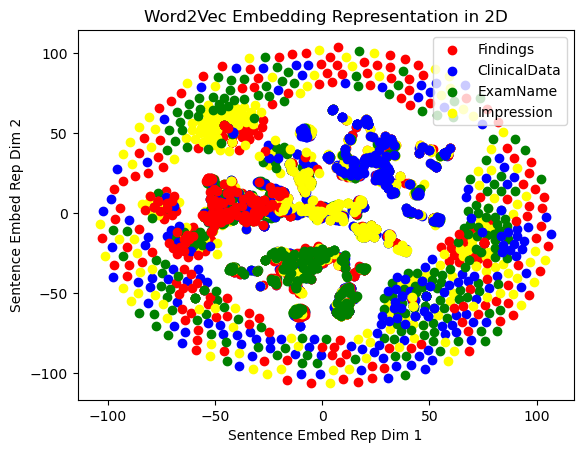

In [159]:
# Create array to map data with columns
map_arr = []
for row in report.itertuples(index=False):
    for col, cell in enumerate(row):
        map_arr.append((cell,int(col)))
Colors = ["red", "blue", "green", "yellow"]
        
        
# Visualize the Low-Dimensional Representation
fig, ax = plt.subplots()
for i in range(X_embedded.shape[0]):
    color_index = map_arr[i][1]
    color = Colors[color_index] # Label --> Color
    ax.scatter(X_embedded[i][0], X_embedded[i][1], c=color)

ax.legend(["Findings", "ClinicalData", "ExamName", "Impression"])
plt.title("Word2Vec Embedding Representation in 2D")
plt.xlabel("Sentence Embed Rep Dim 1")
plt.ylabel("Sentence Embed Rep Dim 2")
plt.show()

In [219]:
# Create feature and outcome arrays for ML task
X_arr = embed_arr
temp_list = []
for row in report.itertuples(index=False):
    for col, cell in enumerate(row):
        temp_list.append(col)
[temp_list.pop(i) for i in index_list] # Remove index with empty sentence  
Y_arr = np.array(temp_list)
        
# Train/Test Split(0.8/0.2)
X_train, X_test, Y_train, Y_test = train_test_split(X_arr, Y_arr, test_size=0.2, random_state=1, shuffle=True)

Accuracy Score: 0.9934469200524246



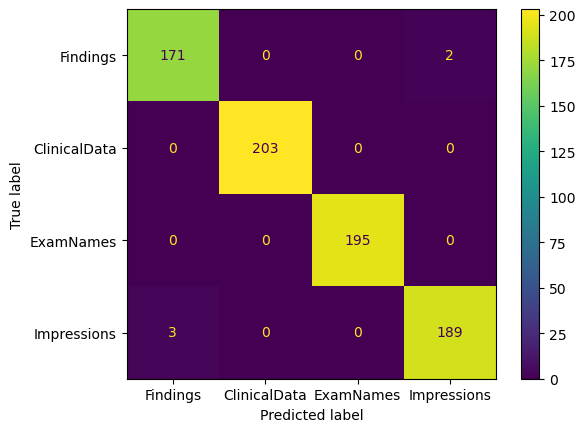

In [228]:
# Model Construction
model = LogisticRegression(penalty='l2', random_state=1, solver='lbfgs', multi_class='multinomial')

# Model Training
model = model.fit(X_train, Y_train)

# Model Prediction
Y_pred = model.predict(X_test)

# Model Evaluation (Accuracy)
score = model.score(X_test, Y_test)
print("Accuracy Score:", score)
print()

# Model Evaluation (Confusion Matrix)
C = confusion_matrix(Y_test, Y_pred, labels=[0,1,2,3])
ConfusionMatrixDisplay(C, display_labels=["Findings", "ClinicalData", "ExamNames", "Impressions"]).plot()

In [229]:
# More Model Evaluation (Classification Report)
print(classification_report(Y_test, Y_pred, target_names=["Findings", "ClinicalData", "ExamNames", "Impressions"]))

              precision    recall  f1-score   support

    Findings       0.98      0.99      0.99       173
ClinicalData       1.00      1.00      1.00       203
   ExamNames       1.00      1.00      1.00       195
 Impressions       0.99      0.98      0.99       192

    accuracy                           0.99       763
   macro avg       0.99      0.99      0.99       763
weighted avg       0.99      0.99      0.99       763



In [ ]:
'''
Observations & Implication:

1. t-SNE Visualization between tfidf and Word2Vec embedding:
tfidf: the shape of the graph is irregular, but you can spot obvious cluster of data points from the same group.
Despite there are places where grouped data points are overlapping.
    Implication: there are documents where share the similar theme or topic belong from the same group, and
    there are few data points shared the similar theme but they are dissimilar group.

Word2Vec: the shape of the graph is obviously a donut shape with clusters in the center. In the donut shape, 
there are groups of different data overlapping to each other
    Implication: the cluster in the center shows that the document shared similar semantic or topic within its 
    own group, where the document in the donut shape are much more complex to classify into distinct group.
    
    The reasoning would be that the sentence vector representation = AVG(word vector representation). However,
    to intepret the sentence, we don't use math operation to add them to convey its meaning. Therefore, this might
    be the limitation of using Word2Vec even though it's able to capture some contextual and semantic information

2. Logistic Regression Modeling:
Both of the embedding methods yielded excellent prediction for text classification. However, tfidf embedding 
has slightly better prediction



Future Direction:
1. Work on Doc2Vec Embedding
2. Tune parameter on Word2Vec
3. Use clustering to visualize
4. Try out what more the word2vec embedding can do
'''

In [ ]:
# To Be Continued ......